# Прогнозирование заказов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-6"><span class="toc-item-num">6&nbsp;&nbsp;</span> Комментарий ревьюера</a></span></li></ul></div>

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Цель нашего проекта — построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

In [1]:
#загружаем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Подготовка

Откроем файл и посмотрим на данные. Открывать файл будем так, чтобы даты распарсились автоматически и ушли в индекс датафрейма.

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Теперь нам необходимо перевести данные в часовой формат. Используем функцию ресемплинга с агрегацией по сумме.

In [5]:
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


В данном шаге мы подготовили данные к дальнейшему анализу, получив почасовую раскладку. В следующем шаге проведем анализ полученных данных.

## Анализ

На этом этапе посмотрим на сезонное распределение и тренд данных. Для начала поймем, за какой период собраны данные.

In [6]:
print('Начало периода: {}, конец периода: {}'.format(data.index.min(), data.index.max()))

Начало периода: 2018-03-01 00:00:00, конец периода: 2018-08-31 23:00:00


Данные за полгода — с начала марта по конец августа 2018 года. Посмотрим на их распределение.

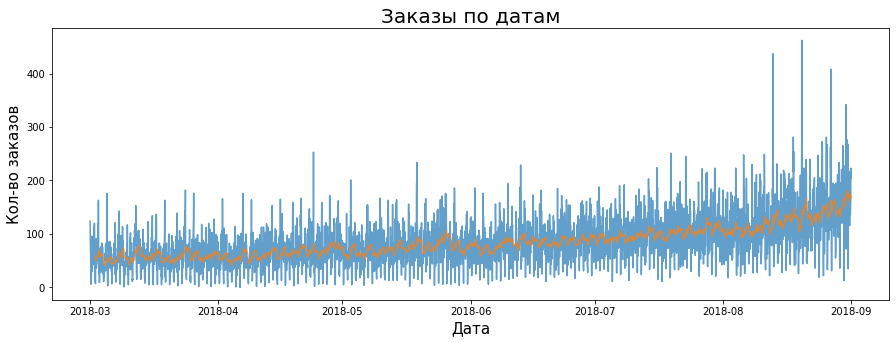

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(data, alpha=0.7)
ax.plot(data.rolling(30).mean(), alpha=0.7)
ax.set_xlabel('Дата', fontsize=15)
ax.set_ylabel('Кол-во заказов', fontsize=15)
ax.set_title('Заказы по датам', fontsize=20);

По этому графику можно судить о том, что среднее количество заказов становится больше к концу лета (может быть связано с отпускным сезоном), либо же количество заказов растет само по себе. Выбросы также становятся заметнее. Т.е. наш ряд — нестационарный. Попробуем декомпозировать данные и посмотреть на сезонность и очевидный тренд в рамках одного месяца, например, июня.

In [8]:
decomposed = seasonal_decompose(data['2018-06':'2018-07'])

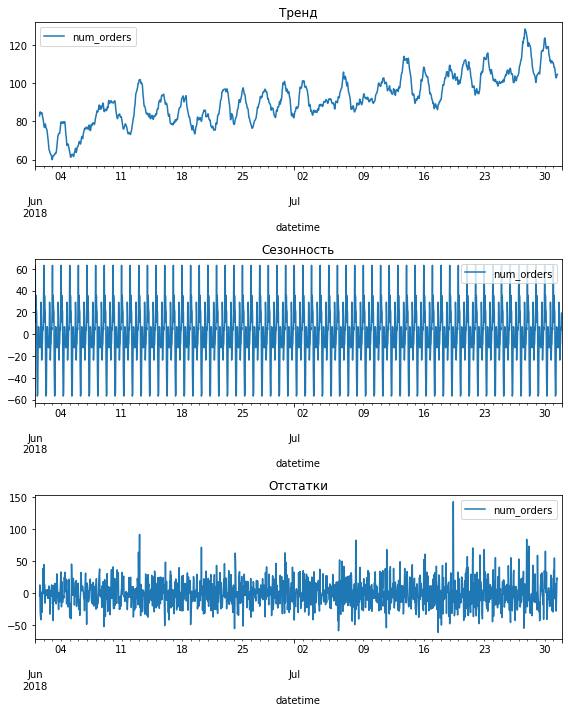

In [9]:
plt.figure(figsize=(8, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Отстатки')
plt.tight_layout()

Опять же прослеживается тренд роста количества заказов, но мы не видим какого-либо понедельного тренда, пики достаточно хаотичны. В то же время график сезонности показывает закономерности в рамках дня. Посмотрим на него поближе.

In [10]:
decomposed_day = seasonal_decompose(data['2018-06-04':'2018-06-05'])

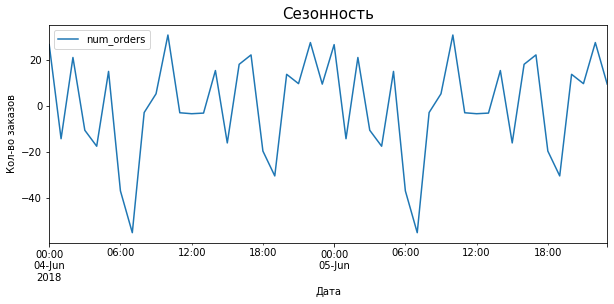

In [11]:
plt.figure(figsize=(10, 4))
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность', fontsize=15)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Кол-во заказов', fontsize=10);

Судя по графику, в конкретные часы заказов больше всего (примерно в 11 утра) и меньше всего (в 7 утра). В районе 6 вечера тоже наблюдается довольно большое кол-во заказов. Далее перейдем к обучению моделей.

## Обучение

В этом шаге мы попробуем обучить несколько моделей и посмотреть, какая лучше всего справится с нашими данными. Начнем с того, что создадим признаки, по которым модели будут обучаться. Признаками станут месяц, число, день недели, разности временного ряда а также скользящее среднее. Напишем функцию для их создания.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Для создания разностей ряда и скользящего среднего возьмем 24-часовой промежуток, поскольку именно такую цикличность имеют наи данные.

In [13]:
make_features(data, 24, 24)
data = data.dropna() # строки с пропусками удалим, их будет всего 24

Выделим признаки и целевой признак, после чего поделим их на три выборки — обучающую, валидационную и тестовую. Перемешивать строки не будем, чтобы не получать информации из будущего.

In [14]:
features = data.drop('num_orders', axis=1).dropna()
target = data['num_orders']

In [15]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
                                                                    features, target, shuffle=False, test_size=0.1)
features_train, features_valid, target_train, target_valid = train_test_split(
                                                    features_train_valid, target_train_valid, shuffle=False, test_size=0.25)
print('Размеры обучающей выборки:', features_train.shape)
print('Размеры валидационной выборки:', features_valid.shape)
print('Размеры тестовой выборки:', features_test.shape)

Размеры обучающей выборки: (2964, 28)
Размеры валидационной выборки: (988, 28)
Размеры тестовой выборки: (440, 28)


Приведем выборки к единому масштабу.

In [16]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

Создадим функцию для метриуи RMSE, которой будем измерять качество предсказания моделей.

In [17]:
def rmse(pred, target):
    return np.sqrt(mean_squared_error(pred, target))

Посмотрим на четыре модели —линейную регрессию, дерево, лес и бустинг. Обучим модели на тренировочной выборке и посмотрим на результаты обучения на валидационной. Затем выберем лучшую и проверим ее работу на тестовых данных.
При обучении мы не будем использовать кросс-валидацию, чтобы опять же не смотреть на данные из будущего.

In [18]:
%%time
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(features_train_scaled, target_train)
lin_predictions = lin_reg.predict(features_valid_scaled)
lin_rmse = rmse(target_valid, lin_predictions)

print('Результаты линейной регрессии:', lin_rmse)

Результаты линейной регрессии: 31.85354385739804
CPU times: user 19.9 ms, sys: 47.4 ms, total: 67.3 ms
Wall time: 10.6 ms


In [19]:
%%time
# Decision Tree
rmse_threshold = 48
for depth in range(10,50,10):
    for leaves in range(10,50,10):
        tree = DecisionTreeRegressor(random_state=12345, max_depth=depth, max_leaf_nodes=leaves)
        tree.fit(features_train_scaled, target_train)
        tree_predictions = tree.predict(features_valid_scaled)
        tree_rmse = rmse(target_valid, tree_predictions)
        if tree_rmse < rmse_threshold:
            best_tree_rmse = tree_rmse
            best_tree = tree
print('Результаты решающего дерева:', best_tree_rmse)

Результаты решающего дерева: 36.447881710109826
CPU times: user 350 ms, sys: 791 µs, total: 351 ms
Wall time: 353 ms


In [20]:
%%time
# Random Forest
for depth in range(10,50,10):
    for leaves in range(10,70,10):
        for estims in range(50,150,50): 
            forest = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=estims, max_leaf_nodes=leaves)
            forest = forest.fit(features_train_scaled, target_train)
            forest_predictions = forest.predict(features_valid_scaled)
            forest_rmse = rmse(target_valid, tree_predictions)
            if forest_rmse < rmse_threshold:
                best_forest_rmse = forest_rmse
                best_forest = forest
print('Результаты случайного дерева:', best_forest_rmse)

Результаты случайного дерева: 36.447881710109826
CPU times: user 58.7 s, sys: 85.1 ms, total: 58.7 s
Wall time: 58.9 s


In [21]:
%%time
# LightGBM
for depth in range(10,50,10):
    for leaves in range(10,50,10):
        lgbm_reg = lgb.LGBMRegressor(boosting='gbdt', random_state=12345, num_leaves=leaves, learning_rate=0.05, max_depth=depth)
        lgbm_trained = lgbm_reg.fit(features_train_scaled, target_train)
        lgbm_predictions = lgbm_reg.predict(features_valid_scaled)
        lgbm_rmse = rmse(target_valid, lgbm_predictions)
        if lgbm_rmse < rmse_threshold:
            best_lgbm_rmse = lgbm_rmse
            best_lgbm = lgbm_reg
print('Результаты бустинга:', best_lgbm_rmse)

Результаты бустинга: 32.90643588971132
CPU times: user 2min 1s, sys: 588 ms, total: 2min 2s
Wall time: 2min 3s


Наилучший результат показала линейная регрессия, поэтому для проверки на тестовых данных будем использовать именно ее.

## Тестирование

В этом шаге мы проверим, насколько хорошо линейная регрессия справится с предсказаниями на тесте.

In [22]:
%%time
lin_predictions_test = lin_reg.predict(features_test_scaled)
lin_rmse_test = rmse(target_test, lin_predictions_test)
lin_rmse_test

CPU times: user 5 ms, sys: 44.9 ms, total: 49.9 ms
Wall time: 92.5 ms


46.935278321141624

Итак, цель проекта — получить показатель RMSE ниже 48 — достигнута. Вероятно, результат получился хуже, чем на валидационной выборке, из-за резкого увеличения среднего количества заказов к августу, а поскольку мы делили данные на выборки без перемешивания, выборки отличаются. Посмотрим, насколько полученный нами результат лучше, чем предсказания по предыдущему значению.

In [23]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print("RMSE предсказание по следующему значению:", rmse(target_test, pred_previous))

RMSE предсказание по следующему значению: 58.91341875235988


В сравнении с предсказанием по следующему значению, наша модель справилась лучше. Возможно, повысить качество предсказания помогло бы использование данных за год, что позволило бы проследить колебания по временам года.